In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from arch import arch_model
from IPython.display import display

In [59]:
#import datasets
spdfpath = '/Users/markoshea/Desktop/Working Directories/Datasets/sp500daily.csv'
spdf = pd.read_csv(spdfpath) 

vixdfpath = '/Users/markoshea/Desktop/Working Directories/Datasets/VIX_History.csv'
vixdf = pd.read_csv(vixdfpath)

qqqdfpath = '/Users/markoshea/Desktop/Working Directories/Datasets/nasdaq-1.xls'
qqqdf = pd.read_excel(qqqdfpath)

In [60]:
spdf

,caldt,spindx
0,1/2/2014,1831.98
1,1/3/2014,1831.37
2,1/6/2014,1826.77
3,1/7/2014,1837.88
4,1/8/2014,1837.49
...,...,...
2511,12/22/2023,4754.63
2512,12/26/2023,4774.75
2513,12/27/2023,4781.58
2514,12/28/2023,4783.35


In [61]:
vixdf

,DATE,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26
...,...,...,...,...,...
8860,02/10/2025,16.58,16.61,15.70,15.81
8861,02/11/2025,16.13,16.42,15.75,16.02
8862,02/12/2025,15.91,17.18,15.64,15.89
8863,02/13/2025,15.97,16.33,14.98,15.10


Q2

In [62]:
#merge dfs on date
spdf['caldt'] = pd.to_datetime(spdf['caldt'])
vixdf['DATE'] = pd.to_datetime(vixdf['DATE'])

spdf.rename(columns={'caldt': 'DATE'}, inplace=True)
merged_df = pd.merge(spdf, vixdf, on='DATE', how='inner')

display(merged_df)

,DATE,spindx,OPEN,HIGH,LOW,CLOSE
0,2014-01-02,1831.98,14.32,14.59,14.00,14.23
1,2014-01-03,1831.37,14.06,14.22,13.57,13.76
2,2014-01-06,1826.77,13.41,14.00,13.22,13.55
3,2014-01-07,1837.88,12.38,13.28,12.16,12.92
4,2014-01-08,1837.49,13.04,13.24,12.86,12.87
...,...,...,...,...,...,...
2511,2023-12-22,4754.63,13.72,13.96,13.00,13.03
2512,2023-12-26,4774.75,13.77,13.80,12.96,12.99
2513,2023-12-27,4781.58,13.02,13.04,12.37,12.43
2514,2023-12-28,4783.35,12.44,12.65,12.38,12.47


In [63]:
#log returns
merged_df['log_return'] = np.log(merged_df['spindx'] / merged_df['spindx'].shift(1))
merged_df.dropna(subset=['log_return'], inplace=True)

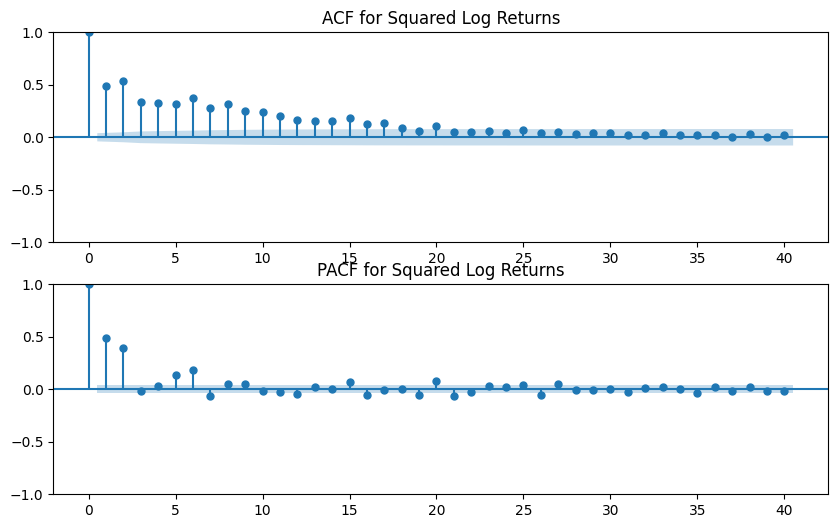

In [64]:
#ACF and PACF for sq log returns
squared_returns = merged_df['log_return'] ** 2

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(squared_returns, ax=ax[0], lags=40)
ax[0].set_title("ACF for Squared Log Returns")
plot_pacf(squared_returns, ax=ax[1], lags=40)
ax[1].set_title("PACF for Squared Log Returns")
plt.show()

Looks like there is long-term dependence since the ACF decays slowly, but PACF falls off by lag 6. Start by fitting a few candidate models: GARCH(1,1), GARCH(6,1), and GARCH(6,2).

In [65]:
#GARCH(6,1)
garch_6_1 = arch_model(merged_df['log_return'] * 100, vol='Garch', p=6, q=1)
result_6_1 = garch_6_1.fit(disp="off")

#GARCH(6,2)
garch_6_2 = arch_model(merged_df['log_return'] * 100, vol='Garch', p=6, q=2)
result_6_2 = garch_6_2.fit(disp="off")

#GARCH(1,1)
garch_1_1 = arch_model(merged_df['log_return'] * 100, vol='Garch', p=1, q=1)
result_1_1 = garch_1_1.fit(disp="off")

print("GARCH(1,1) Summary:\n", result_1_1.summary())
print("GARCH(6,1) Summary:\n", result_6_1.summary())
print("GARCH(6,2) Summary:\n", result_6_2.summary())

#AIC and BIC
models = {"GARCH(1,1)": result_1_1, "GARCH(6,1)": result_6_1, "GARCH(6,2)": result_6_2}
for name, model in models.items():
    print(f"{name}: AIC = {model.aic:.2f}, BIC = {model.bic:.2f}")

GARCH(1,1) Summary:
                      Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3191.21
Distribution:                  Normal   AIC:                           6390.43
Method:            Maximum Likelihood   BIC:                           6413.75
                                        No. Observations:                 2515
Date:                Fri, Feb 21 2025   Df Residuals:                     2514
Time:                        00:52:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0771  1.450e-02      5.318

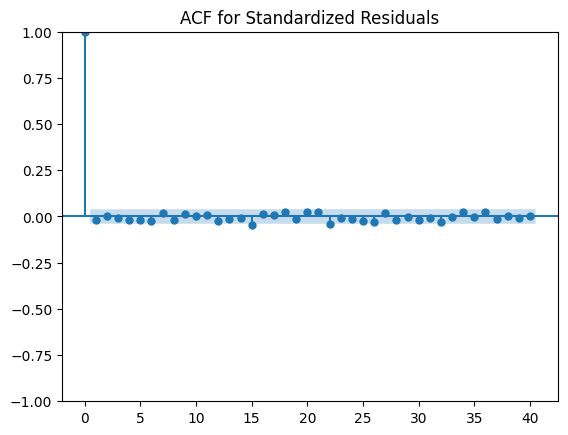

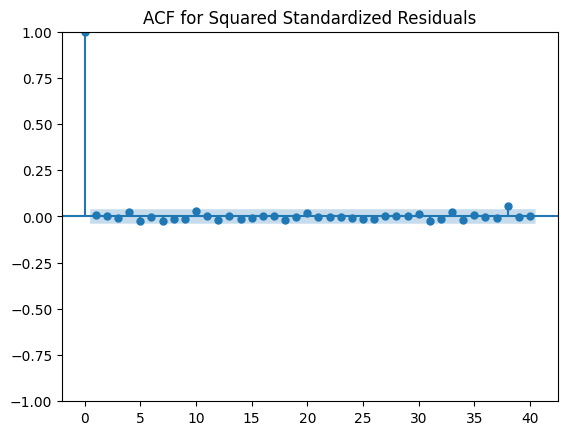

In [66]:
#ACF for residuals for GARCH(1,1)
residuals_1_1 = result_1_1.std_resid
plot_acf(residuals_1_1, lags=40)
plt.title("ACF for Standardized Residuals")
plt.show()

#ACF for squared residuals
plot_acf(residuals_1_1 ** 2, lags=40)
plt.title("ACF for Squared Standardized Residuals")
plt.show()

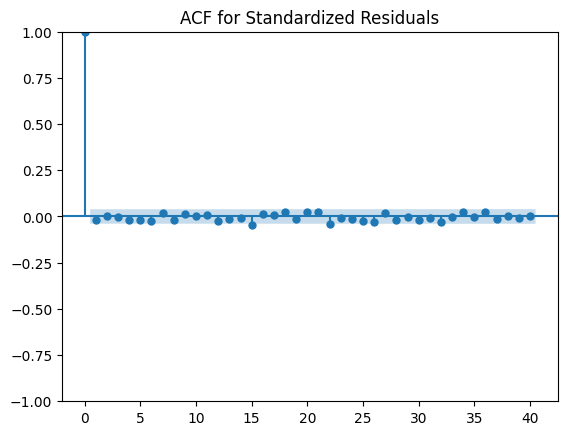

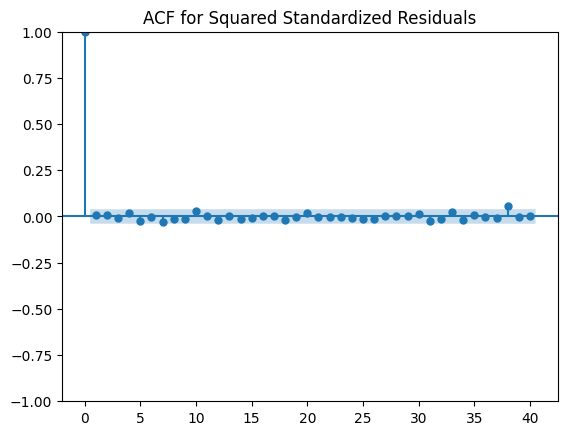

In [67]:
#ACF for residuals for GARCH(6,1)
residuals_6_1 = result_6_1.std_resid
plot_acf(residuals_6_1, lags=40)
plt.title("ACF for Standardized Residuals")
plt.show()

#ACF for sq residuals
plot_acf(residuals_6_1**2, lags=40)
plt.title("ACF for Squared Standardized Residuals")
plt.show()

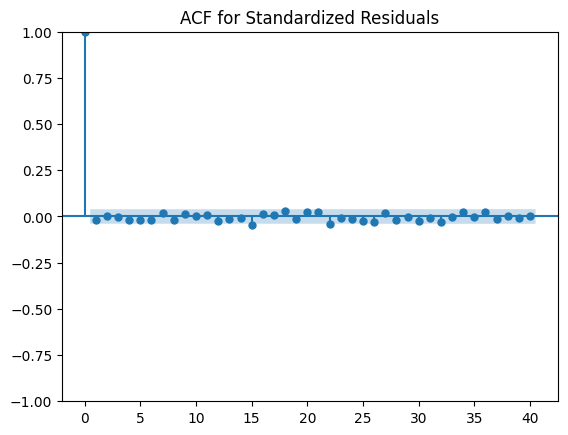

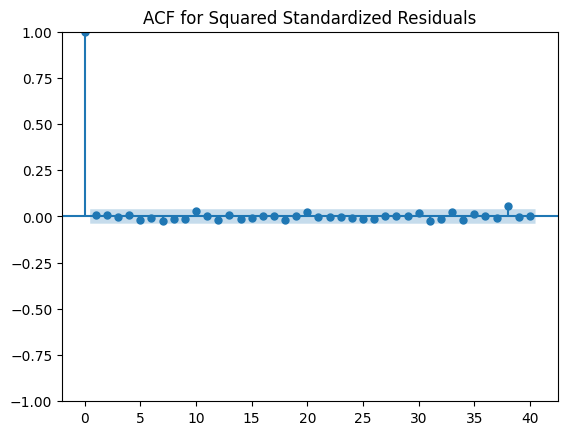

In [68]:
#ACF for residuals for GARCH(6,2)
residuals_6_2 = result_6_2.std_resid
plot_acf(residuals_6_2, lags=40)
plt.title("ACF for Standardized Residuals")
plt.show()

#ACF for sq residuals
plot_acf(residuals_6_2 ** 2, lags=40)
plt.title("ACF for Squared Standardized Residuals")
plt.show()

In [69]:
#convert VIX closing prices into daily variance
merged_df['Daily_Variance'] = (merged_df['CLOSE'] / 100) ** 2 / 252
display(merged_df)

,DATE,spindx,OPEN,HIGH,LOW,CLOSE,log_return,Daily_Variance
1,2014-01-03,1831.37,14.06,14.22,13.57,13.76,-0.000333,0.000075
2,2014-01-06,1826.77,13.41,14.00,13.22,13.55,-0.002515,0.000073
3,2014-01-07,1837.88,12.38,13.28,12.16,12.92,0.006063,0.000066
4,2014-01-08,1837.49,13.04,13.24,12.86,12.87,-0.000212,0.000066
5,2014-01-09,1838.13,12.83,13.26,12.83,12.89,0.000348,0.000066
...,...,...,...,...,...,...,...,...
2511,2023-12-22,4754.63,13.72,13.96,13.00,13.03,0.001659,0.000067
2512,2023-12-26,4774.75,13.77,13.80,12.96,12.99,0.004223,0.000067
2513,2023-12-27,4781.58,13.02,13.04,12.37,12.43,0.001429,0.000061
2514,2023-12-28,4783.35,12.44,12.65,12.38,12.47,0.000370,0.000062


In [70]:
#lagged daily variance column
merged_df['Lagged_VIX_Variance'] = merged_df['Daily_Variance'].shift(1)
merged_df.dropna(subset=['Lagged_VIX_Variance', 'log_return'], inplace=True)

In [124]:
#GARCH(1,1) model w lagged var
garch_exog = arch_model(
    merged_df['log_return'], 
    vol='Garch',
    p=1, q=1,
    x=merged_df[['Lagged_VIX_Variance']] 
)

result_exog = garch_exog.fit(disp="off")
print(result_exog.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8378.56
Distribution:                  Normal   AIC:                          -16749.1
Method:            Maximum Likelihood   BIC:                          -16725.8
                                        No. Observations:                 2514
Date:                Fri, Feb 21 2025   Df Residuals:                     2513
Time:                        13:27:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.9446e-04  2.455e-06    323.659      0.000 [7.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001257. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Q2 (c)
We see that for our GARCH(1,1) with a lagged VIX value, the coefficients are all significant and nonzero. The AIC and BIC are 6389.22 and 6412.54, respectively. Without the VIX, the GARCH(1,1) had AIC and BIC values 6390.43 and 6413.75, respectively. Technically, these values are smaller, but by a margin that is so small as to be insignificant. However, we find that including the lagged variable has effectively no impact on the magnitude or significance of the coefficients for beta or alpha, so we are included to choose the simpler model without the lagged variable.

Q3

In [72]:
qqqdf

,NQTIMESINCEMIDNIGHT,NQ_RET,DAY
0,33599860,NaN,1
1,33899996,-0.001143,1
2,34199999,-0.000143,1
3,34499888,0.001715,1
4,34799976,0.000428,1
...,...,...,...
2107,51899952,-0.000685,32
2108,52199927,0.000411,32
2109,52499997,0.000958,32
2110,52799776,-0.000411,32


Q3 (a)

In [101]:
#get hours 
qqqdf['time_of_day'] = qqqdf['NQTIMESINCEMIDNIGHT'] / 1000  
qqqdf['time_of_day_hours'] = qqqdf['time_of_day'] / 3600  

In [102]:
#make r^2
qqqdf['r_squared'] = qqqdf['NQ_RET'] ** 2  

qqqdf = qqqdf.replace([np.inf, -np.inf], np.nan)  
qqqdf = qqqdf.dropna(subset=['r_squared', 'time_of_day_hours']) 

In [103]:
#OLS regression to estimate and plot phi(t)
#used ax^2 + bx+ c as quadratic for phi
X = np.column_stack([
    np.ones(len(qqqdf)),  
    qqqdf['time_of_day_hours'], 
    qqqdf['time_of_day_hours'] ** 2
])
y = qqqdf['r_squared']

model = sm.OLS(y, X).fit()
qqqdf['phi_t'] = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              r_squared   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     21.08
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           8.60e-10
Time:                        13:05:19   Log-Likelihood:                 25211.
No. Observations:                2111   AIC:                        -5.042e+04
Df Residuals:                    2108   BIC:                        -5.040e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.511e-05   2.19e-06      6.911      0.0

Q3 (b)

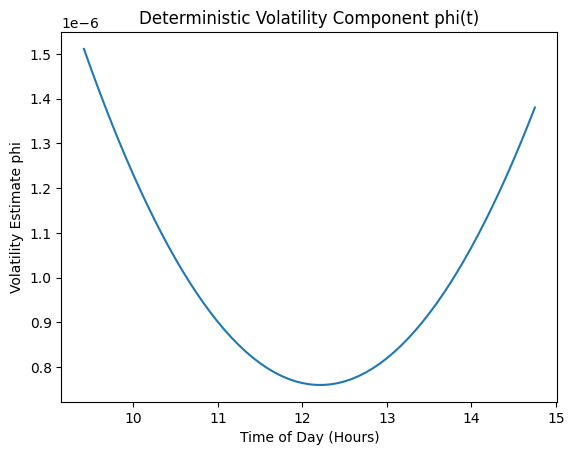

In [126]:
#phi(t) plot for a single day (day 1)
day_selected = 1
single_day_df = qqqdf[qqqdf['DAY'] == day_selected].copy()

single_day_df = single_day_df.sort_values(by='time_of_day_hours')

plt.plot(single_day_df['time_of_day_hours'], single_day_df['phi_t'], label='phi(t)')
plt.xlabel('Time of Day (Hours)')
plt.ylabel('Volatility Estimate phi')
plt.title('Deterministic Volatility Component phi(t)')
plt.show()

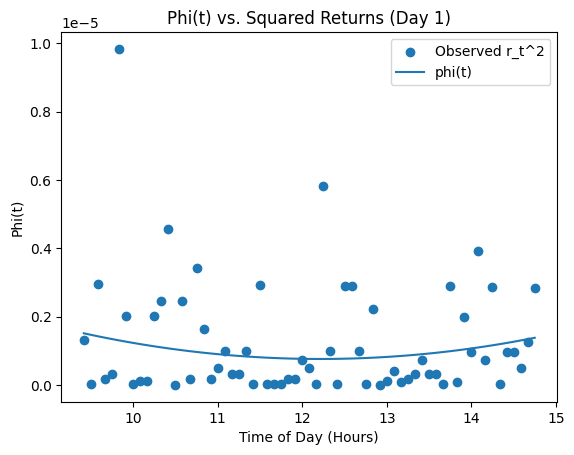

In [ ]:
#plot phi w data points
plt.scatter(single_day_df['time_of_day_hours'], single_day_df['r_squared'], 
            label='Observed r_t^2')

plt.plot(single_day_df['time_of_day_hours'], single_day_df['phi_t'], 
         label='phi(t)')

plt.xlabel('Time of Day (Hours)')
plt.ylabel('Phi')
plt.title('Phi vs. Squared Returns')
plt.legend()
plt.show()

Q3 (c)

In [ ]:
#create r tilde series
qqqdf['r_tilde'] = qqqdf['NQ_RET'] / np.sqrt(qqqdf['phi_t'])

In [114]:
#fit a GARCH(1,1) on r tilde
garch_model = arch_model(qqqdf['r_tilde'], vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp="off") 

print(garch_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                r_tilde   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2928.40
Distribution:                  Normal   AIC:                           5864.80
Method:            Maximum Likelihood   BIC:                           5887.42
                                        No. Observations:                 2111
Date:                Fri, Feb 21 2025   Df Residuals:                     2110
Time:                        13:15:52   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0414  1.929e-02      2.144  3.206e-02 [3.

In [116]:
#get GARCH parameters
alpha0 = garch_results.params['omega'] 
alpha1 = garch_results.params['alpha[1]']
beta1 = garch_results.params['beta[1]']  

unconditional_variance = alpha0 / (1 - alpha1 - beta1)
print(f"Unconditional Variance: {unconditional_variance:.4f}")

Unconditional Variance: 1.0079


Q3 (d)

In [ ]:
#compute sqrt(phi)
single_day_df['sqrt_phi_t'] = np.sqrt(single_day_df['phi_t'])

#compute sqrt(h_t) * sqrt(phi_t)
single_day_df['h_t'] = garch_results.conditional_volatility ** 2  
single_day_df['sqrt_ht_sqrt_phi_t'] = np.sqrt(single_day_df['h_t']) * single_day_df['sqrt_phi_t']

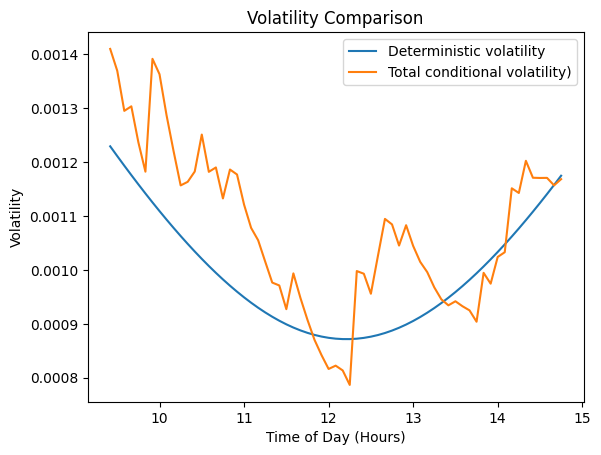

In [125]:
#plot
plt.plot(single_day_df['time_of_day_hours'], single_day_df['sqrt_phi_t'], 
         label='Deterministic volatility')

plt.plot(single_day_df['time_of_day_hours'], single_day_df['sqrt_ht_sqrt_phi_t'], 
         label='Total conditional volatility)')

plt.xlabel('Time of Day (Hours)')
plt.ylabel('Volatility')
plt.title('Volatility Comparison')
plt.legend()
plt.show()